In [1]:
import torch
import os
import gc
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import pytorch_lightning as pl
from tqdm import tqdm
from modules.losses import SupConLoss
from modules.backbones import ResNet50
from modules.datasets import MultiLabelDataset
from modules.siamese import ContrastiveNetwork
from modules.callbacks import LossTracker,ModelSaver
from torchvision.transforms import RandAugment
from modules.trainer import Trainer
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") # we want to run Single-Core in the Notebook -> Ignore this warning
warnings.simplefilter(action='ignore', category=FutureWarning)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SAVE_DIR = "./runs/augmentation_size"

C:\Users\Lukas\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = MultiLabelDataset(
    "./tiny-imagenet-200/train",
    cache_in_ram=True,
    transform=None,
    max_classes=50
    )
len(dataset)

25000

In [3]:
#Build the DataLoaders
from modules.datasets import AugmentingDataset
import torchdatasets as td

BATCH_SIZE = 128
SAMPLES = 20 #20 Images Per Class

train_indices = []
val_indices = []
for dataset_range in dataset.ranges:
    #Only take n_samples from each dataset
    train_indices += list(range(dataset_range.start,dataset_range.start+SAMPLES))
    val_indices += list(range(dataset_range.start+400,dataset_range.stop))
    
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
val_dataset = td.datasets.WrapDataset(val_dataset)
val_dataset.map(
    td.maps.To(
        transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])
    ,0))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,pin_memory=True)

def Build_Augmented_Set(dataset,factor=None):
    if factor == None:
        dataset = td.datasets.WrapDataset(dataset)
        dataset.map(
            td.maps.To(
                transforms.Compose(
                    [
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                    ])
            ,0))
        return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)
    augmented_set = AugmentingDataset(dataset,RandAugment(),transforms=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]),factor=factor)
    return DataLoader(augmented_set, batch_size=BATCH_SIZE, shuffle=True,pin_memory=True)

In [4]:
Epochs = 5
augment_sizes = [None,2,4,8,16]
for augment_size in augment_sizes: 

    siamese_model = ContrastiveNetwork(ResNet50(pretrained=True,freeze=False),SupConLoss())
    
    model_dir = os.path.join(SAVE_DIR,str(augment_size) if augment_size else "Baseline")
    if os.path.isdir(model_dir):
        continue
    os.makedirs(model_dir,exist_ok=True)
    
    lossTracker = LossTracker()
    modelSaver = ModelSaver(model_dir)
    train_loader = Build_Augmented_Set(train_dataset,augment_size)
    
    trainer = Trainer(max_epochs=Epochs,callbacks=[lossTracker,modelSaver])
    trainer.fit(model=siamese_model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    lossTracker.save(model_dir)
    torch.cuda.empty_cache()
    gc.collect()

In [5]:
from modules.knn import KNN

knns = {}

for augment_size in augment_sizes: 
    train_loader = Build_Augmented_Set(train_dataset,augment_size)
    model:torch.nn.Module = ResNet50()
    augmenter_name = str(augment_size) if augment_size else "Baseline"
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,augmenter_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)
    knns[augmenter_name] = KNN(model,train_loader,os.path.join(SAVE_DIR,augmenter_name))

In [6]:
results = {}

for augment_size in augment_sizes: 
    model:torch.nn.Module = ResNet50()
    augmenter_name = str(augment_size) if augment_size else "Baseline"
    model.load_state_dict(torch.load(os.path.join(SAVE_DIR,augmenter_name,"checkpoints",f"epoch_{Epochs-1}.pth")))
    model = model.to(DEVICE)

    embeddings = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader,augmenter_name):
            img,label = batch
            embedding = model(img.to(DEVICE)).cpu().numpy()
            embeddings.append(embedding)  
            labels.append(label)
    
    results[augmenter_name] = (np.vstack(embeddings),np.vstack(labels).reshape(-1))

16: 100%|██████████| 40/40 [00:01<00:00, 25.08it/s]


In [7]:
from sklearn.metrics import f1_score  

for key in results:
    embeddings,labels = results[key]
    predictions = knns[key].querry_labels(embeddings)
    print(f"{key} F1-Score: {f1_score(predictions,labels,average='macro'):.3f}")

Baseline F1-Score: 0.306
2 F1-Score: 0.352
4 F1-Score: 0.437
8 F1-Score: 0.518
16 F1-Score: 0.569


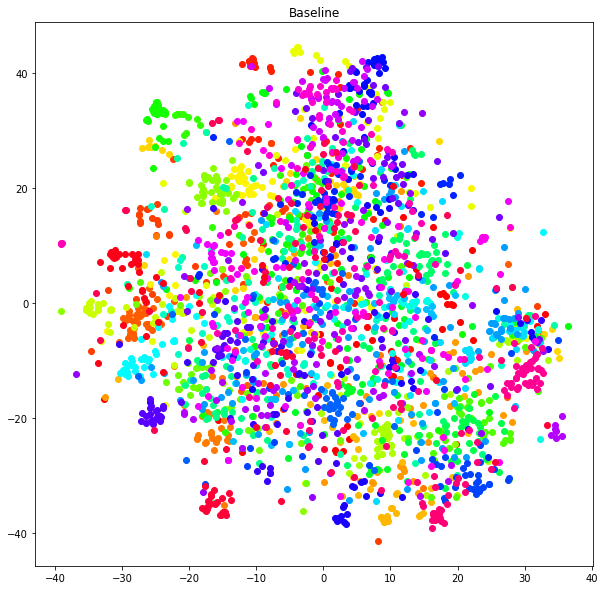

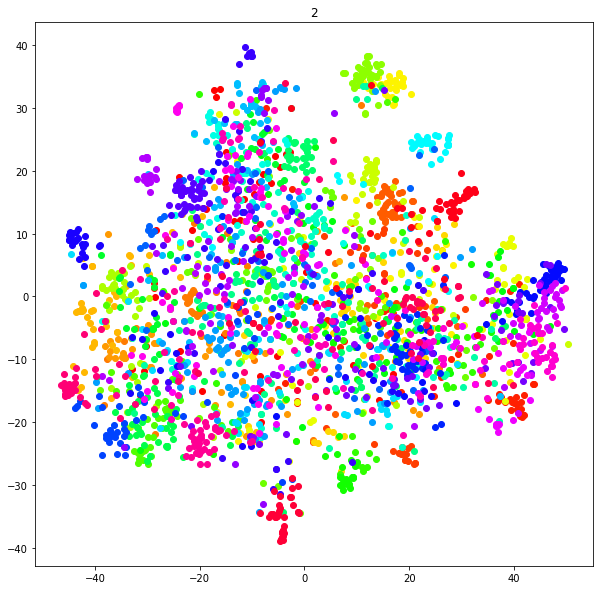

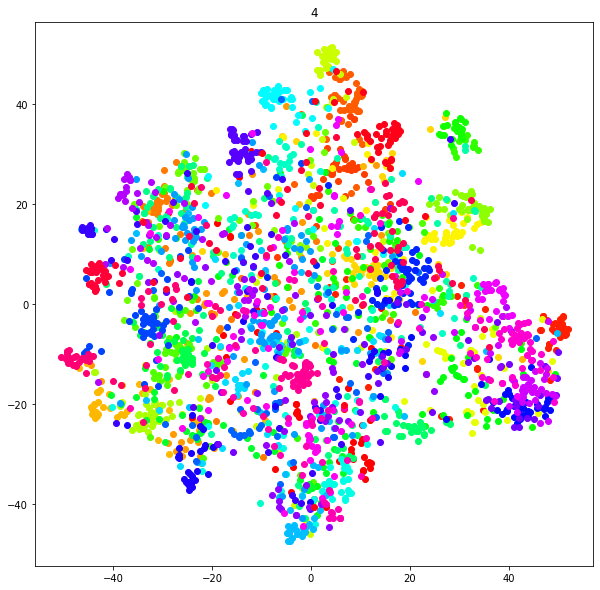

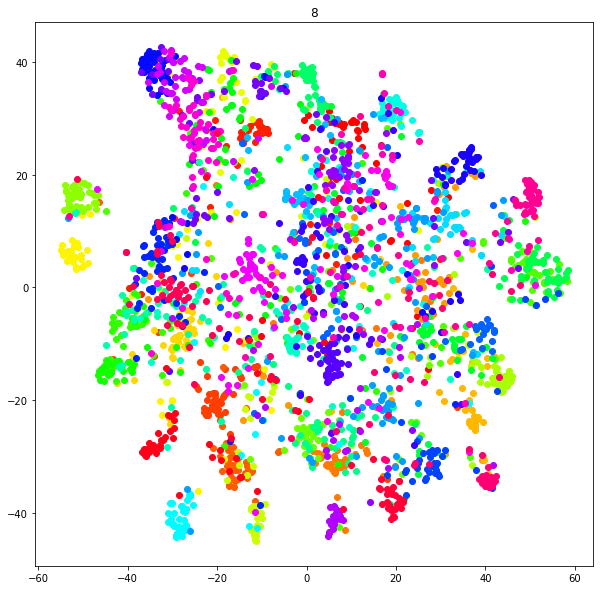

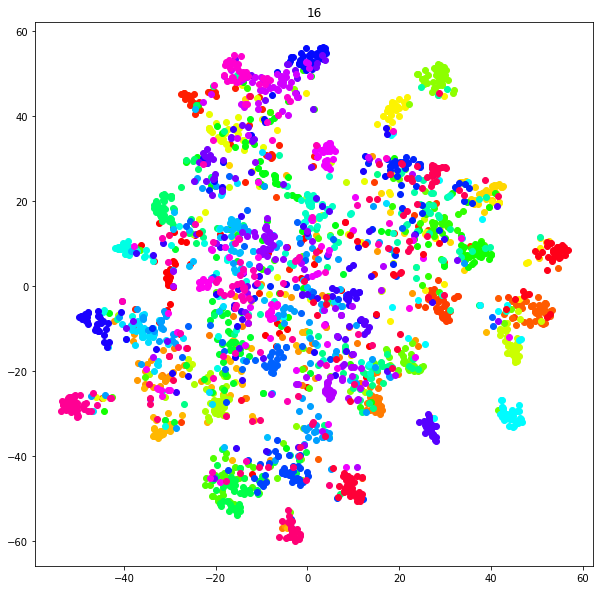

In [8]:
import matplotlib.pyplot as plt
from modules.plotting import plot_tsne

for key in results:
    embeddings,labels = results[key]
    plt.figure(figsize=(10,10))
    
    plot_tsne(embeddings,labels,50,max_points_per_class=50)
    plt.title(key)
    plt.show()